# Cài đặt các thư viện cần thiết

In [1]:
!pip install transformers datasets
!pip install scikit-learn pandas seaborn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 5.1 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cesium 0.12.4 requires numpy<3.0,>=2.0, but you have numpy 1.26.4 which is incompatible.
bigframes 1.42.0 requires rich<14,>=12.4.4, but you have rich 14.0.0 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.9.0.13 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cudnn-cu12==9.1.0.70; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cudnn-cu12 9.3.0.75 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cufft-

# Load và xử lý dữ liệu

In [2]:
import json
import pandas as pd

# Đọc các file JSON
def load_data(json_path):
    with open(json_path, 'r') as f:
        data = json.load(f)
    return pd.DataFrame(data)

train_df = load_data("/kaggle/input/np-data/train.json")
val_df = load_data("/kaggle/input/np-data/val.json")
test_df = load_data("/kaggle/input/np-data/test.json")

# Gán nhãn số
label2id = {"SUPPORTS": 0, "REFUTES": 1}
train_df["label"] = train_df["label"].map(label2id)
val_df["label"] = val_df["label"].map(label2id)
test_df["label"] = test_df["label"].map(label2id)

In [3]:
texts_train = train_df["claim"] + " [SEP] " + train_df["evidence"]
texts_val = val_df["claim"] + " [SEP] " + val_df["evidence"]
texts_test = test_df["claim"] + " [SEP] " + test_df["evidence"]

In [4]:
labels_train = train_df["label"].values
labels_val = val_df["label"].values
labels_test = test_df["label"].values

# Token hóa và chuyển sang Dataset

In [5]:
from transformers import XLMRobertaTokenizer

tokenizer = XLMRobertaTokenizer.from_pretrained("xlm-roberta-base")

train_encodings = tokenizer(list(texts_train), truncation=True, padding=True, max_length=256)
val_encodings = tokenizer(list(texts_val), truncation=True, padding=True, max_length=256)
test_encodings = tokenizer(list(texts_test), truncation=True, padding=True, max_length=256)


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.10M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/615 [00:00<?, ?B/s]

In [6]:
import torch

class FactCheckDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

train_dataset = FactCheckDataset(train_encodings, labels_train)
val_dataset = FactCheckDataset(val_encodings, labels_val)
test_dataset = FactCheckDataset(test_encodings, labels_test)


# Huấn luyện mô hình XML-Roberta

In [7]:
from transformers import XLMRobertaTokenizer, XLMRobertaForSequenceClassification, Trainer, TrainingArguments
import torch
from sklearn.metrics import precision_recall_fscore_support, accuracy_score

class FactCheckingModelTrainer:
    def __init__(self, model_name="xlm-roberta-base", num_labels=2, max_length=256):
        self.model_name = model_name
        self.num_labels = num_labels
        self.max_length = max_length
        self.best_metric = float('-inf')

        self.tokenizer = XLMRobertaTokenizer.from_pretrained(self.model_name)
        self.model = XLMRobertaForSequenceClassification.from_pretrained(
            self.model_name,
            num_labels=self.num_labels
        )
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.model.to(self.device)
        self.trainer = None

    @staticmethod
    def compute_metrics(pred):
        labels = pred.label_ids
        preds = pred.predictions.argmax(-1)
        precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='weighted')
        acc = accuracy_score(labels, preds)
        return {
            'accuracy': acc,
            'f1': f1,
            'precision': precision,
            'recall': recall
        }

    def fit(self,
      train_dataset,
      valid_dataset=None,
      output_dir='./results',
      num_train_epochs=3,
      per_device_train_batch_size=8,
      per_device_eval_batch_size=8,
      warmup_steps=500,
      weight_decay=0.01,
      logging_steps=100,
      metric_for_best_model="f1"):

      training_args = TrainingArguments(
          output_dir=output_dir,
          num_train_epochs=num_train_epochs,
          per_device_train_batch_size=per_device_train_batch_size,
          per_device_eval_batch_size=per_device_eval_batch_size,
          learning_rate=2e-5,
          warmup_ratio=0.1,
          weight_decay=weight_decay,
          logging_dir=f'{output_dir}/logs',
          logging_steps=logging_steps,
          save_steps=500,
          save_total_limit=3,
          metric_for_best_model=metric_for_best_model,
          greater_is_better=True,
          disable_tqdm=False,
          report_to="none",
          max_grad_norm=1.0
      )
      self.trainer = Trainer(
          model=self.model,
          args=training_args,
          train_dataset=train_dataset,
          eval_dataset=valid_dataset,
          compute_metrics=self.compute_metrics if valid_dataset is not None else None,
      )

      print("Bắt đầu huấn luyện mô hình...")
      self.trainer.train()
      print("Huấn luyện hoàn tất.")

      # Đánh giá trên tập validation
      if valid_dataset is not None:
          print("\nĐánh giá trên tập validation:")
          eval_results = self.trainer.evaluate()
          print("\nKết quả đánh giá:")
          print(f"Accuracy: {eval_results['eval_accuracy']:.4f}")
          print(f"F1-score: {eval_results['eval_f1']:.4f}")
          print(f"Precision: {eval_results['eval_precision']:.4f}")
          print(f"Recall: {eval_results['eval_recall']:.4f}")

    def predict(self, statement, evidence):
        self.model.eval()

        full_text = f"{statement} [SEP] {evidence}"
        inputs = self.tokenizer(
            full_text,
            return_tensors="pt",
            truncation=True,
            padding='max_length',
            max_length=self.max_length
        )
        inputs = {k: v.to(self.device) for k, v in inputs.items()}

        with torch.no_grad():
            outputs = self.model(**inputs)
        logits = outputs.logits
        probabilities = torch.softmax(logits, dim=1)
        predicted_class_id = torch.argmax(probabilities, dim=1).item()
        label_map = {0: "SUPPORTS", 1: "REFUTES"}
        predicted_label = label_map.get(predicted_class_id, str(predicted_class_id))
        return predicted_label, probabilities.cpu().numpy()[0]

    def save_model(self, save_path="./fine_tuned_xlm_roberta_factcheck"):
        print(f"Lưu mô hình vào {save_path}")
        self.model.save_pretrained(save_path)
        self.tokenizer.save_pretrained(save_path)

2025-05-31 08:23:40.034911: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748679820.218677      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748679820.274439      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [8]:
trainer = FactCheckingModelTrainer()
trainer.fit(train_dataset, valid_dataset=val_dataset)

model.safetensors:   0%|          | 0.00/1.12G [00:00<?, ?B/s]

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Bắt đầu huấn luyện mô hình...


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Step,Training Loss
100,0.688700
200,0.559400
300,0.466600
400,0.410300
500,0.358700
600,0.324300
700,0.270000
800,0.269200
900,0.255600
1000,0.283300


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Huấn luyện hoàn tất.

Đánh giá trên tập validation:


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(



Kết quả đánh giá:
Accuracy: 0.9189
F1-score: 0.9190
Precision: 0.9194
Recall: 0.9189


In [9]:
trainer.save_model("./fine_tuned_phobert_factcheck")

Lưu mô hình vào ./fine_tuned_phobert_factcheck


# Hàm đánh giá test_evaluate

In [10]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

def evaluate_on_testset(trainer, test_dataset, label_names=["SUPPORTS", "REFUTES"]):
    print("📊 Đang đánh giá trên tập test...")
    predictions = trainer.trainer.predict(test_dataset)
    y_true = predictions.label_ids
    y_pred = np.argmax(predictions.predictions, axis=1)

    # In báo cáo phân loại
    print("\n=== Báo cáo phân loại ===")
    print(classification_report(y_true, y_pred, target_names=label_names, digits=4))

    # Tính ma trận nhầm lẫn
    cm = confusion_matrix(y_true, y_pred)

    # Vẽ biểu đồ
    plt.figure(figsize=(6, 5))
    sns.set(font_scale=1.2)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=label_names, yticklabels=label_names)
    plt.xlabel("Dự đoán")
    plt.ylabel("Thực tế")
    plt.title("🔍 Ma trận nhầm lẫn trên tập test")
    plt.tight_layout()
    plt.show()

📊 Đang đánh giá trên tập test...


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(



=== Báo cáo phân loại ===
              precision    recall  f1-score   support

    SUPPORTS     0.9444    0.9134    0.9287       670
     REFUTES     0.8966    0.9332    0.9145       539

    accuracy                         0.9222      1209
   macro avg     0.9205    0.9233    0.9216      1209
weighted avg     0.9231    0.9222    0.9224      1209



/tmp/ipykernel_19/4267098624.py:26: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from current font.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


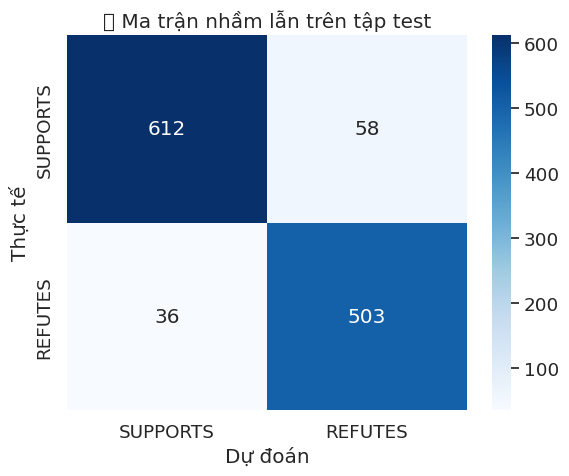

In [11]:
evaluate_on_testset(trainer, test_dataset, label_names=["SUPPORTS", "REFUTES"])